# Text Generation with RNN + Attention

There 2 implementations of Attention.

1. Manual computating Attention weight
2. keras.layers.Attention

# Setup


In [ ]:
# @title Import Packages
import numpy as np
import re
from pathlib import Path
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Dropout
from tensorflow.keras.layers import Permute, Flatten, Activation, RepeatVector, Multiply, Lambda
from tensorflow.keras.layers import Attention

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K

In [ ]:
# @title Mount GDrive
train_model = True

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Unit of Token
token_type = 'word'

In [ ]:
# @title Download Dataset
!mkdir -p /content/aesop
!wget https://www.gutenberg.org/cache/epub/11339/pg11339.txt -O /content/aesop/data.txt

--2024-07-20 02:42:12--  https://www.gutenberg.org/cache/epub/11339/pg11339.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 241922 (236K) [text/plain]
Saving to: ‘/content/aesop/data.txt’

/content/aesop/data 100%[===================>] 236.25K  --.-KB/s    in 0.1s    

2024-07-20 02:42:12 (2.12 MB/s) - ‘/content/aesop/data.txt’ saved [241922/241922]



# Dataset

## Normalize Dataset

In [ ]:
# load the text file and extract the main stories
seq_length = 20

filename = "/content/aesop/data.txt"
with open(filename, encoding='utf-8-sig') as f:
    text = f.read()


#removing text before and after the main stories
start = text.find("THE FOX AND THE GRAPES\n\n\n")
end = text.find("ILLUSTRATIONS\n\n\n[")
text = text[start:end]
len(text)

197444

In [ ]:
# normalize the text

start_story = '| ' * seq_length
text = start_story + text # add a prefix indicating a beginning of stories

text = text.lower()
text = text.replace('\n\n\n\n\n', start_story) # assign identifiers to chapter breaks
text = text.replace('\n', ' ')
text = re.sub('  +', '. ', text).strip()
text = text.replace('..', '.')

text = re.sub('([!"#$%&()*+,-./:;<=>?@[\]^_`{|}~])', r' \1 ', text) # extract symbols
text = re.sub('\s{2,}', ' ', text)
len(text)

213716

In [ ]:
text

' | | | | | | | | | | | | | | | | | | | | the fox and the grapes . a hungry fox saw some fine bunches of grapes hanging from a vine that was trained along a high trellis , and did his best to reach them by jumping as high as he could into the air . but it was all in vain , for they were just out of reach : so he gave up trying , and walked away with an air of dignity and unconcern , remarking , " i thought those grapes were ripe , but i see now they are quite sour . " | | | | | | | | | | | | | | | | | | | | the goose that laid the golden eggs . a man and his wife had the good fortune to possess a goose which laid a golden egg every day . lucky though they were , they soon began to think they were not getting rich fast enough , and , imagining the bird must be made of gold inside , they decided to kill it in order to secure the whole store of precious metal at once . but when they cut it open they found it was just like any other goose . thus , they neither got rich all at once , as the

## Make Vocabluary and Convert Words to Tokens

In [ ]:
if token_type == 'word':
    tokenizer = Tokenizer(char_level = False, filters = '')
else:
    # char_level: if True, every character will be treated as a token.
    tokenizer = Tokenizer(char_level = True, filters = '', lower = False)

tokenizer.fit_on_texts([text])

total_words = len(tokenizer.word_index) + 1 # add 1 because the index number starts from 1, not 0
token_list = tokenizer.texts_to_sequences([text])[0]

In [ ]:
total_words

4169

In [ ]:
print(tokenizer.word_index)
print(token_list[:500])

{'|': 1, ',': 2, 'the': 3, 'and': 4, '.': 5, 'a': 6, 'to': 7, '"': 8, 'of': 9, 'he': 10, 'his': 11, 'was': 12, 'you': 13, 'in': 14, 'him': 15, 'it': 16, 'for': 17, 'i': 18, 'but': 19, 'that': 20, 'with': 21, 'said': 22, 'they': 23, 'at': 24, 'as': 25, 'when': 26, 'on': 27, 'so': 28, 'by': 29, ':': 30, 'one': 31, 'had': 32, ';': 33, 'be': 34, 'them': 35, 'up': 36, 'all': 37, 'who': 38, '-': 39, 'her': 40, 'my': 41, 'is': 42, 'out': 43, 'me': 44, 'not': 45, 'your': 46, 'were': 47, 'which': 48, 'have': 49, 'their': 50, 'no': 51, 'lion': 52, 'she': 53, 'if': 54, 'into': 55, 'fox': 56, 'an': 57, 'what': 58, 'ass': 59, '!': 60, 'time': 61, 'from': 62, 'are': 63, 'came': 64, '?': 65, 'man': 66, 'do': 67, 'about': 68, 'there': 69, 'wolf': 70, 'then': 71, 'upon': 72, 'himself': 73, 'this': 74, 'day': 75, 'would': 76, 'some': 77, 'once': 78, 'will': 79, 'very': 80, 'went': 81, 'well': 82, 'than': 83, 'down': 84, 'replied': 85, 'got': 86, 'off': 87, 'could': 88, 'away': 89, 'see': 90, 'good': 91,

## Make Training Data

In [ ]:
# X: each instance has tokens whose length is seq_length
# y: each label is a token coming to next and encoded as one-hot
def generate_sequences(token_list, step):
    X = []
    y = []

    for i in range(0, len(token_list) - seq_length, step):
        X.append(token_list[i: i + seq_length]) # store seq_length (20) tokens
        y.append(token_list[i + seq_length]) # store a token coming next

    # the output of the model is a probability distribution of the vocabularies
    # that appears next in the sequence data, so we OneHot encode the correct label
    # to compute the loss with 'categorical_crossentropy'
    y = to_categorical(y, num_classes = total_words)

    num_seq = len(X)
    print('Number of sequences:', num_seq, "\n")

    return X, y, num_seq

step = 1
seq_length = 20

X, y, num_seq = generate_sequences(token_list, step)

X = np.array(X)
y = np.array(y)
X.shape, y.shape

Number of sequences: 50416 



((50416, 20), (50416, 4169))

In [ ]:
X[100]

array([  18,  144,  260,  940,   47, 1177,    2,   19,   18,   90,  115,
         23,   63,  360, 2229,    5,    8,    1,    1,    1])

In [ ]:
y[100]

array([0., 1., 0., ..., 0., 0., 0.], dtype=float32)

# Attention by Manual Computing Weight

The embedding layer is essentially a lookup table for integer tokens, converting each token into a vector of length embedding_size.

Therefore, the number of weights trained in this layer is equal to the vocabulary size multiplied by embedding_size.

```
| Token |            Embedding (100dim)           |
|-------+-----------+-------+-----+-------+-------|
|     1 |     -0.13 |  0.45 | ... |  0.13 | -0.04 |
|     2 |      0.22 |  0.56 | ... |  0.24 | -0.63 |
|   ... |       ... |   ... | ... |   ... |   ... |
|  4168 |      0.16 | -0.70 | ... | -0.35 |  1.02 |
|  4169 |     -0.98 | -0.45 | ... | -0.15 | -0.52 |
```


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            416900    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 (None, None, 256)            365568    ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, None, 1)              257       ['lstm[0][0]']                
                                                                                              

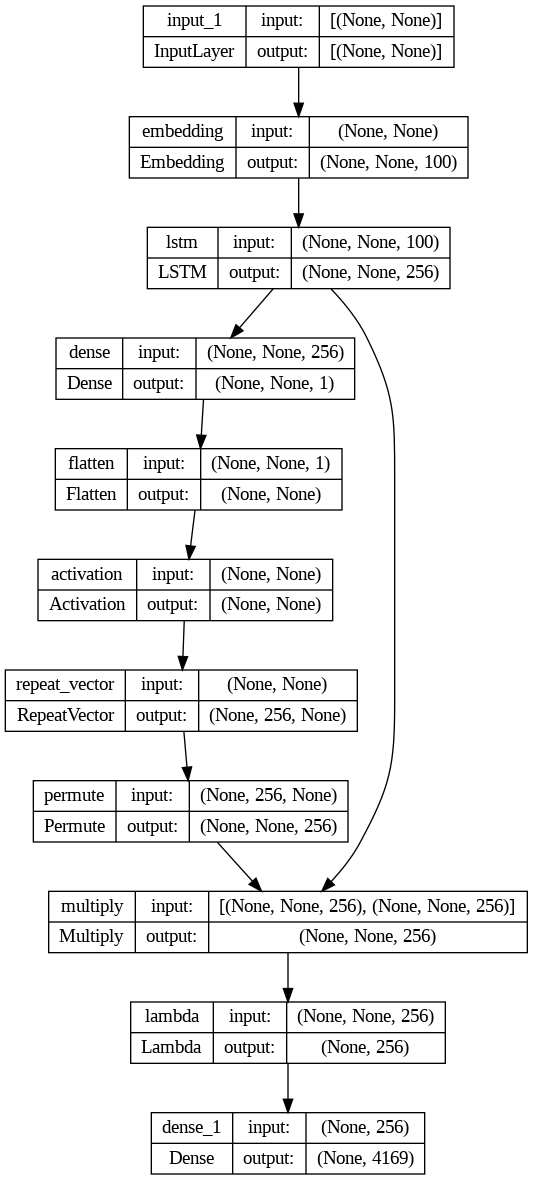

In [ ]:
# @title Define Attention

dpath = Path('/content/drive/MyDrive/Colab Notebooks/study/GenText')
dpath_model = dpath / 'saved_models/attention-manual/aesop_no_dropout_100'

if not train_model:
    model = load_model(dpath_model)
else:
    n_units = 256  # Number of nodes in the LSTM cell
    embedding_size = 100  # Embedding size

    # Define input layer
    text_in = Input(shape=(None,))

    # Embedding layer
    embedding = Embedding(total_words, embedding_size)  # Lookup table of total_words x embedding_size
    x = embedding(text_in) # 20(seq_len) x 100

    # LSTM layer with return_sequences=True to return the full sequence
    x = LSTM(n_units, return_sequences=True)(x) # 20 x 256

    # Attention mechanism
    # Compute attention scores
    e = Dense(1, activation='tanh')(x) # 20 x 1
    e = Flatten()(e) # 20

    alpha = Activation('softmax')(e) # 20

    # Compute the context vector as the weighted sum of LSTM outputs
    c = RepeatVector(n_units)(alpha) # 256 x 20
    c = Permute([2, 1])(c) # 20 x 256
    c = Multiply()([x, c]) # 20 x 256
    # Reduces the sequence dimension by summing up the attention-weighted outputs across all time steps
    c = Lambda(lambda x: K.sum(x, axis=1))(c) # 256

    # Dense layer
    text_out = Dense(total_words, activation='softmax')(c) # 4169 distribution probability of vocabulary table

    # Define the model
    model = Model(text_in, text_out)

    opti = RMSprop(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opti)

model.summary()
plot_model(model, show_shapes=True)

In [ ]:
# @title Helper Function to Generate Text with Temperature

def sample_with_temp(preds, temperature=1.0):
    # sample an index from a probability distribuiton by weighting with temperature
    preds = np.asarray(preds).astype('float64') # (4169,)
    preds = preds ** (1 / temperature)
    preds = preds / np.sum(preds)
    return np.random.choice(len(preds), p=preds)

def generate_text(seed_text, next_words, model, max_sequence_len, temp):
    output_text = seed_text
    seed_text = start_story + seed_text

    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = token_list[-max_sequence_len:]
        token_list = np.reshape(token_list, (1, max_sequence_len))

        probs = model.predict(token_list, verbose=0)[0]
        y_class = sample_with_temp(probs, temperature = temp)

        if y_class == 0:
            output_word = ''
        else:
            output_word = tokenizer.index_word[y_class]

        if output_word == "|":
            break

        if token_type == 'word':
            output_text += output_word + ' '
            seed_text += output_word + ' '
        else:
            output_text += output_word + ' '
            seed_text += output_word + ' '

    return output_text

In [ ]:
def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 50

    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))

In [ ]:
%%time

epochs =  100 # 1000
batch_size = 64 # 32
callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)

Epoch 1/100
788/788 [==============================] - ETA: 0s - loss: 5.5573Temp 0.2
the the the the the the . the the the . the the , , , the , , , , , , of , , , , , , , , , , , , , , , , , , . , , , , , , , 
Temp 0.33
the and the the the the the . . and the and the a , the of , he , , , , , , , , , , , , , , , , , the , the the , , , , , , , , a , 
Temp 0.5
, the the the the a the the for wolf and the the , the at , " the should , to of " the by i , , said . , of , the . the you and he , a , , , , , of you the 
Temp 1.0
mouse approaching the the . and a - to the bored the before swam case his in grazing to to very the blotched at for capsized . strikes will children delayed 
788/788 [==============================] - 30s 34ms/step - loss: 5.5573
Epoch 2/100
788/788 [==============================] - ETA: 0s - loss: 5.2618Temp 0.2
the the the the the the the the the and the the and a and a and , , , the , the , , a , , , , , and , , , and , , , , , , the the , the the the , , 
Temp 

In [ ]:
seed_text = "the frog and the snake . the frog went to "
gen_words = 50 # 500
temp = 0.1

print (generate_text(seed_text, gen_words, model, seq_length, temp))

the frog and the snake . the frog went to lived a beasts and journey and ran in the hunting of the meat of its in . beast as the the dogs in which he was seen to the hand of get out about ; the while the man came the man , was caught once the cloak , and 


## Export Model

In [ ]:
dpath_model = dpath / 'saved_models/attention-manual/aesop_no_dropout_100'
model.save(dpath_model)

# Attention by keras.layers.Attention

## Define Attention

In [ ]:
n_units = 256  # Number of nodes in the LSTM cell
embedding_size = 100  # Embedding size

# Define input layer
text_in = Input(shape=(None,))

# Embedding layer
embedding = Embedding(total_words, embedding_size)  # Lookup table of total_words x embedding_size
x = embedding(text_in) # 20(seq_len) x 100

# LSTM layer with return_sequences=True to return the full sequence
lstm_out = LSTM(n_units, return_sequences=True)(x) # 20 x 256

# Attention layer
attention = Attention()([lstm_out, lstm_out]) # 20 x 256

# reduces the sequence dimension by summing up the attention-weighted outputs across all time steps.
attention_output = tf.reduce_sum(attention, axis=1)  # Reduce along the sequence axis. 256

# Dense layer
text_out = Dense(total_words, activation='softmax')(attention_output)

# Define the model
model = Model(text_in, text_out)

# Compile the model
opti = RMSprop(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opti)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, None, 100)            416900    ['input_3[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, None, 256)            365568    ['embedding_2[0][0]']         
                                                                                                  
 attention (Attention)       (None, None, 256)            0         ['lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']        

In [ ]:
%%time

def on_epoch_end(epoch, logs):
    seed_text = ""
    gen_words = 50

    print('Temp 0.2')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.2))
    print('Temp 0.33')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.33))
    print('Temp 0.5')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 0.5))
    print('Temp 1.0')
    print (generate_text(seed_text, gen_words, model, seq_length, temp = 1))

epochs =  100 # 1000
batch_size = 64 # 32
callback = LambdaCallback(on_epoch_end=on_epoch_end)
model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks = [callback], shuffle = True)

Epoch 1/100
788/788 [==============================] - ETA: 0s - loss: 5.4056Temp 0.2

Temp 0.33

Temp 0.5
the 
Temp 1.0

788/788 [==============================] - 14s 14ms/step - loss: 5.4056
Epoch 2/100
788/788 [==============================] - ETA: 0s - loss: 5.1015Temp 0.2

Temp 0.33

Temp 0.5

Temp 1.0

788/788 [==============================] - 7s 9ms/step - loss: 5.1015
Epoch 3/100
788/788 [==============================] - ETA: 0s - loss: 4.8471Temp 0.2
the the the . . a man was was a wild a ass a ass of a ass of , , which the was , , a ass was , a ass a ass a ass a ass a ass a ass a ass of a ass , a ass 
Temp 0.33
the the ass and . a fox a man a a - of a ass a - - - - , , a was was - - - - - - - - - - - - - - - - - - - - - - - - - 
Temp 0.5
the the and . a was man his - a a - of a of of a herd , were , , , had went , he day , he was the was , , a was was was of of , his had was was of for , the 
Temp 1.0
the man head begged the thrifty . a his defended farmer was his manners

In [ ]:
dpath = Path('/content/drive/MyDrive/Colab Notebooks/study/GenText')
dpath_model = dpath / 'saved_models/attention/aesop_no_dropout_100'
model.save(dpath_model)